## Digit Image Annotation Dataset Generator

This notebook will identify misclassified digits in raw images and copy those raw images to a training dataset directory for manual annotation.

In [1]:
import os
import os.path as osp
import numpy as np
import pandas as pd
import celldom
import matplotlib.pyplot as plt
import plotnine as pn
from celldom.config import experiment_config
from celldom.core import cytometry
from celldom.execute import processing
from celldom.extract import ALL_IMAGES

#### Select Images to Re-process

In [16]:
OUTPUT_DIR = '20180911-G3-yl'
#OUTPUT_DIR = '20180908-G3-full'
EXP_CONFIG = 'experiment_example_G3'
DATA_DIR = osp.join(celldom.get_data_dir(), 'output', OUTPUT_DIR)
DATA_DIR

'/lab/data/celldom/output/20180911-G3-yl'

In [3]:
config = experiment_config.get_exp_config_by_name(EXP_CONFIG)
store = cytometry.get_readonly_datastore(DATA_DIR)

In [4]:
df = store.get('apartment')
image_file_map = store.get('acquisition').set_index('acq_id')['raw_image_path']
df['raw_image_path'] = df['acq_id'].map(image_file_map)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 132407 entries, 0 to 5
Data columns (total 37 columns):
acq_apartment             132407 non-null object
acq_cohort                132407 non-null object
acq_color                 132407 non-null object
acq_condition             132407 non-null object
acq_datetime              132407 non-null datetime64[ns]
acq_hours                 132407 non-null object
acq_id                    132407 non-null object
acq_processed_at          132407 non-null datetime64[ns]
acq_pump                  132407 non-null object
acq_street                132407 non-null object
apt_id                    132407 non-null int64
apt_image_height          132407 non-null int64
apt_image_width           132407 non-null int64
apt_num                   132407 non-null object
apt_num_digit_scores      132407 non-null object
cell_area_mean            118881 non-null float64
cell_area_p10             118881 non-null float64
cell_area_p50             118881 non-null floa

In [5]:
chip_config = config.get_chip_config()
dfe = df[ \
    ~df['apt_num'].astype(int).between(*chip_config['apt_num_range']) | \
    ~df['st_num'].astype(int).between(*chip_config['st_num_range']) \
]

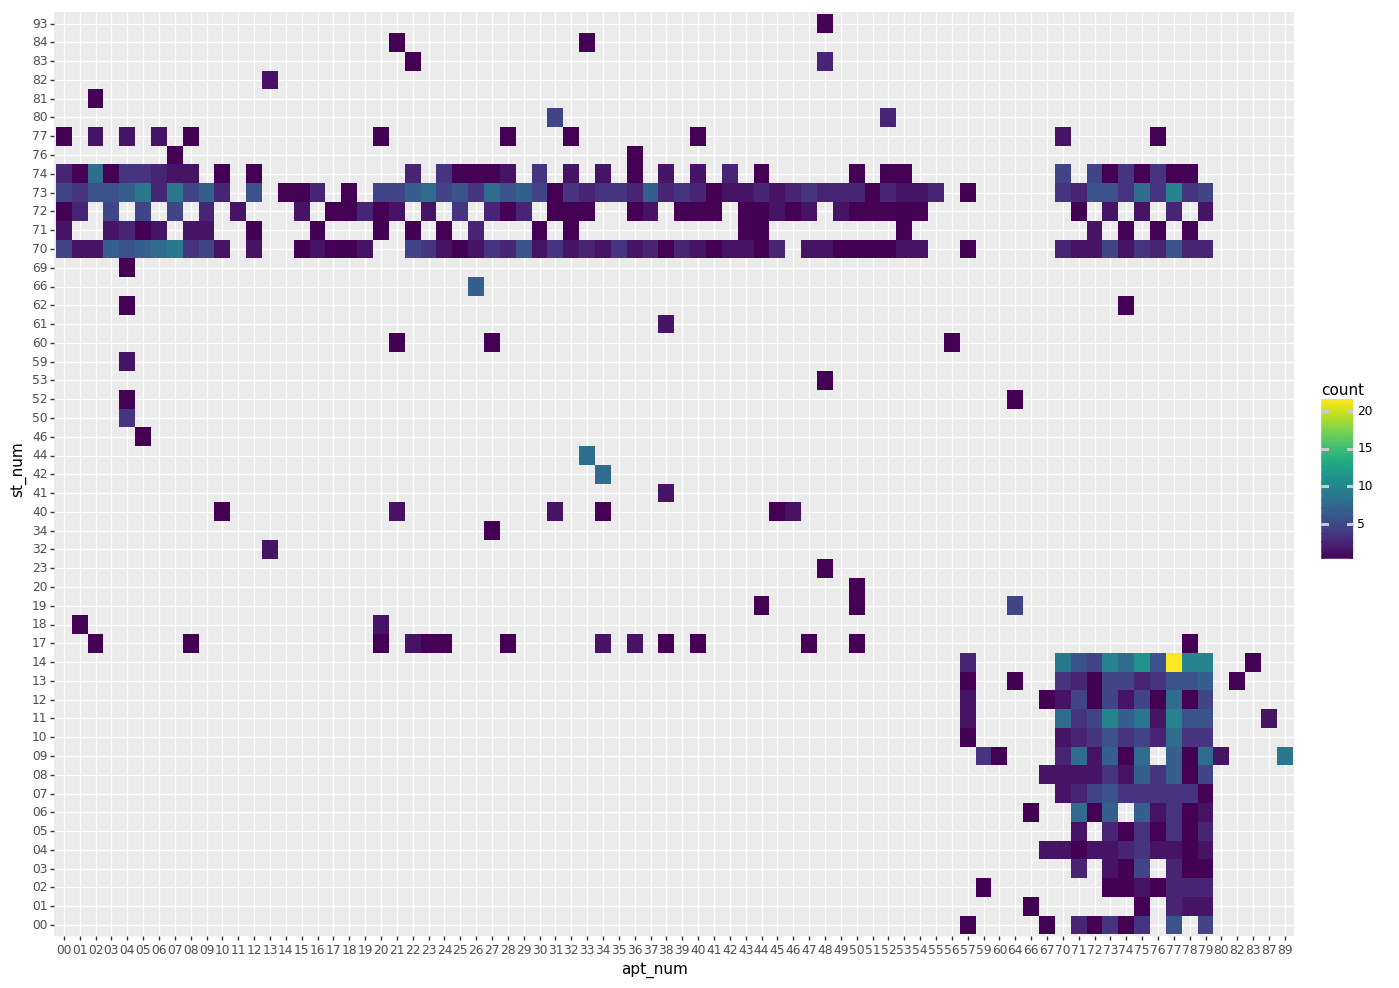

<ggplot: (8730307709006)>

In [6]:
(
    pn.ggplot(
        dfe.groupby(['apt_num', 'st_num']).size().rename('count').reset_index(), 
        pn.aes(x='apt_num', y='st_num', fill='count')
    ) +
    pn.geom_tile() + 
    pn.theme(figure_size=(16,12))
)

In [7]:
dfe.iloc[0]

acq_apartment                                                           010
acq_cohort                                                            0.1uM
acq_color                                                            Orange
acq_condition                                                             1
acq_datetime                                            2018-06-14 23:50:00
acq_hours                                                                 0
acq_id                                     f0e372e9c6a54c011cd7040f12e65c0a
acq_processed_at                                        2018-09-13 04:21:26
acq_pump                                                            gravity
acq_street                                                              000
apt_id                                                                    6
apt_image_height                                                        224
apt_image_width                                                         235
apt_num     

#### Reprocess Selected Images

In [8]:
image_files = [
    f.replace('/lab/data/celldom/JeffsData', '/lab/data/celldom/dataset/dataset05')
    for f in dfe['raw_image_path'].unique()
]
len(image_files)

601

In [13]:
sample_files = pd.Series(image_files).sample(n=500, random_state=celldom.seed).tolist()
len(sample_files)

500

In [14]:
output_dir = '/tmp/digit_annot_generator'
if osp.exists(output_dir):
    !rm -rf /tmp/digit_annot_generator/*

In [15]:
%%time
res = processing.run_cytometer(
    config, output_dir, sample_files, 
    max_failures=10000, dpf=ALL_IMAGES, 
    return_results=True, save_results=False
)

Using TensorFlow backend.
100%|██████████| 500/500 [14:55<00:00,  1.79s/it]

CPU times: user 19min 41s, sys: 22min 22s, total: 42min 4s
Wall time: 15min 14s


#### Extract Digit Images for OOB Addresses

In [32]:
import tqdm
apt_range, st_range = chip_config['apt_num_range'], chip_config['st_num_range']


def extract_bad_digits(res):
    df_digit = []
    
    def add_images(acq_id, apt_id, imgs, typ, digits):
        assert isinstance(digits, str)
        assert len(imgs) == len(digits)
        for i in range(len(imgs)):
            filename = '{}-{}-{}-{}-{}.png'.format(acq_id, apt_id, typ, i, digits[i])
            df_digit.append(dict(
                acq_id=acq_id, apt_id=apt_id, type=typ, filename=filename, 
                label=digits[i], image=imgs[i]
            ))
        
    for row in tqdm.tqdm(res):
        df = row[1] # Get apartment data frame
        mask = df['apt_num'].astype(int).between(*chip_config['apt_num_range']) & \
            df['st_num'].astype(int).between(*chip_config['st_num_range'])

        # Loop through single rows for each apartment
        for i, r in df.loc[~mask.values].iterrows():
            acq_id, apt_id = r['acq_id'], r['apt_id']
            apt_num, st_num = r['apt_num'], r['st_num']

            # Save all apartment or street digit images if the combination of them is OOB
            if int(apt_num) < apt_range[0] or int(apt_num) > apt_range[1]:
                add_images(acq_id, apt_id, r['apt_num_digit_images'], 'apt', apt_num)
            if int(st_num) < st_range[0] or int(st_num) > st_range[1]:
                add_images(acq_id, apt_id, r['st_num_digit_images'], 'st', st_num)

    return pd.DataFrame(df_digit)

df_digit = extract_bad_digits(res)

100%|██████████| 500/500 [00:01<00:00, 341.27it/s]


In [33]:
len(df_digit)

2492

In [34]:
df_digit.groupby('type').size()

type
apt    1200
st     1292
dtype: int64

In [35]:
df_digit.groupby('label').size()

label
0     225
1     102
2     125
3     295
4     151
5      99
6      69
7    1265
8      74
9      87
dtype: int64

In [36]:
df_digit.groupby(['type', 'label']).size()

type  label
apt   0         45
      1         51
      2         36
      3         71
      4         47
      5         93
      6         47
      7        673
      8         57
      9         80
st    0        180
      1         51
      2         89
      3        224
      4        104
      5          6
      6         22
      7        592
      8         17
      9          7
dtype: int64

### Export Images for Annotation

In [38]:
RESULT_DIR = osp.join(celldom.get_dataset_dir(), 'training', 'digit', 'r0.6', 'manual', 'single')
RESULT_DIR

'/lab/data/celldom/dataset/training/digit/r0.6/manual/single'

In [39]:
df_digit['filename'].head(3).values

array(['9641a967d199a6094082cbe401312c1b-0-st-0-7.png',
       '9641a967d199a6094082cbe401312c1b-0-st-1-2.png',
       '494e840ffea66f61e7211340977ebe0d-4-st-0-6.png'], dtype=object)

In [42]:
from skimage import io as sk_io

for i, r in tqdm.tqdm(df_digit.iterrows()):
    path = osp.join(RESULT_DIR, r['filename'])
    img = r['image']
    sk_io.imsave(path, img)

534it [00:00, 757.44it/s]/usr/local/lib/python3.5/dist-packages/skimage/io/_io.py:140: UserWarning: /lab/data/celldom/dataset/training/digit/r0.6/manual/single/3c8011a0bf4440152efcfd7c42882b50-3-st-1-1.png is a low contrast image
  warn('%s is a low contrast image' % fname)
2492it [00:03, 782.18it/s]
